In [1]:
import numpy as np
import datetime
import time

In [2]:
BOARD_ROWS = 5
BOARD_COLS = 6
START = (0, 0)

In [3]:
class State:

    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.state = state    # tuple of the coordinate
        self.is_end = False

    def check_end(self):
        if self.state == START:
            self.is_end = True

    def next_position(self, action):
        if action == "up":
            next_state = (self.state[0] - 1, self.state[1])
        elif action == "down":
            next_state = (self.state[0] + 1, self.state[1])
        elif action == "left":
            next_state = (self.state[0], self.state[1] - 1)
        else:
            next_state = (self.state[0], self.state[1] + 1)
        if (next_state[0] >= 0) and (next_state[0] < BOARD_ROWS):
            if (next_state[1] >= 0) and (next_state[1] < BOARD_COLS):
                return next_state
        return self.state


In [4]:
class Agent:

    def __init__(self):
        self.actions = ["up", "down", "left", "right"]  # space
        self.State = State()
        self.is_end = self.State.is_end
        self.alpha = 0.05
        self.exp_rate = 1
        self.decay_gamma = 0.9
        self.Q_values = {}  # init Q values (dict)
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0
        self.past_all = []
        for i in range(BOARD_ROWS):
            t = []
            for j in range(BOARD_COLS):
                t.append(False)
            self.past_all.append(t)

        self.steps = []
        self.done = False
        self.step = 0
        self.states=[]
        self.all_states=[]    

    def optimal_action(self):
        max_value = -10000000000
        action = ""
        for a in self.actions:
            next_value = self.Q_values[self.State.state][a]
            if next_value >= max_value:
                action = a
                max_value = next_value
        return action

    def get_actions(self):
        i, j = self.State.state[0], self.State.state[1]
        potential_position = []
        if i + 1 < BOARD_ROWS and self.past_all[i+1][j] is False:
            potential_position.append("down")
        if i - 1 > 0 and self.past_all[i-1][j] is False:
            potential_position.append("up")
        if j + 1 < BOARD_COLS and self.past_all[i][j+1] is False:
            potential_position.append("right")
        if j - 1 > 0 and self.past_all[i][j-1] is False:
            potential_position.append("left")
        return potential_position

#     def get_action(self):
#         """
#         The agent should choose randomly among the positions that have
#         not been visited, and if all possible positions are visited,
#         then move randomly and receive a negative reward
#         """
#         actions = self.get_actions()
#         if np.random.uniform(0, 1) <= self.exp_rate:
#             b = True
#             for a in actions:
#                 position = self.State.next_position(a)
#                 if self.past_all[position[0]][position[1]] is False:
#                     b = False
#             if b:
#                 action = np.random.choice(actions)
#                 return action
#             # Else try to get an available unvisited position randomly
#             else:
#                 while True:
#                     action = np.random.choice(actions)
#                     next_state = self.State.next_position(action)
#                     if self.past_all[next_state[0]][next_state[1]] is False:
#                         return action
#                     else:
#                         continue
#         else:
#             return self.optimal_action()

    def get_action(self):
        actions = self.get_actions()
        if actions == []:
            self.done = True
            return ""
        if np.random.uniform(0, 1) <= self.exp_rate:
            return np.random.choice(actions)
        else:
             return self.optimal_action()


    def give_reward(self):
        reward = 1
        if self.State.state == START and self.check_all_past():
            reward += 1
#         else:   
#             reward -= (BOARD_ROWS*BOARD_COLS-self.step)
        return reward

    def set_action(self, action):
        self.step += 1
        curr_state = self.State.state
        
        self.states.append(curr_state)
        
        self.past_all[curr_state[0]][curr_state[1]] = True
        next_state = self.State.next_position(self.get_action())
        self.State = State(state=next_state)
        reward = self.give_reward()
        if self.past_all[next_state[0]][next_state[1]] is False:
            self.past_all[next_state[0]][next_state[1]] = True
        else:
            reward -= 1
            self.done = True
        qs_of_next_state = []
        for q_value in self.Q_values[next_state]:
            qs_of_next_state.append(self.Q_values[next_state][q_value])
        delta = self.alpha * (reward + self.decay_gamma * (max(qs_of_next_state)) -
                              self.Q_values[curr_state][action])
        self.Q_values[curr_state][action] = round(self.Q_values[curr_state][action] + delta, 10)

    def reset(self):
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.past_all[i][j] = False
        self.State = State()
        self.is_end = self.State.is_end
        self.done = False
        self.step = 0
        self.states=[]

    def check_all_past(self):
        for i in self.past_all:
            for j in i:
                if j is False:
                    return False
        return True                

    def train(self, rounds=1000):
        print("Training...")
        for r in range(rounds):
            self.reset()
            self.exp_rate *= 0.99
            step = 0
            while True:
                action = self.get_action()
                if self.done:
                    self.all_states.append(self.states)
                    break
                self.set_action(action)
                self.State.check_end()
                self.is_end = self.State.is_end
                step += 1
                if self.is_end and self.check_all_past():
                    self.all_states.append(self.states)
                    break
                if self.done:
                    self.all_states.append(self.states)
                    break
            self.steps.append(step)
        print("Training finished!")

    def show_path(self):
        for i in range(BOARD_ROWS):
            print('---------------------------------------')
            row_string = "| "
            for j in range(BOARD_COLS):
                best_move = ""
                best_val = -10000000000000000
                for a in self.Q_values[(i,j)]:
                    if self.Q_values[(i, j)][a] > best_val:
                        best_val = self.Q_values[(i,j)][a]
                        best_move = a
                row_string = row_string + " " + best_move + " |"
            print(row_string)
        print('---------------------------------------')

In [5]:
agent = Agent()
start_time = datetime.datetime.now()
agent.train()
end_time = datetime.datetime.now()
time_period = (end_time - start_time).total_seconds()
print(agent.Q_values)

Training...
Training finished!
{(0, 0): {'up': 0, 'down': 3.0433646504, 'left': 0, 'right': 8.308178831}, (0, 1): {'up': 0, 'down': 2.5369998778, 'left': 0, 'right': 8.1247699059}, (0, 2): {'up': 0, 'down': 3.3029630421, 'left': 0, 'right': 7.9209680315}, (0, 3): {'up': 0, 'down': 2.1634634832, 'left': 0, 'right': 7.6945089856}, (0, 4): {'up': 0, 'down': 7.442875947, 'left': 0, 'right': 3.1216333815}, (0, 5): {'up': 0, 'down': 0.1763633947, 'left': 0, 'right': 0.5165915176}, (1, 0): {'up': 0, 'down': 0.7525758823, 'left': 0, 'right': 2.4810154908}, (1, 1): {'up': 0, 'down': 1.4362189374, 'left': 0, 'right': 3.1555840244}, (1, 2): {'up': 0, 'down': 1.4253910095, 'left': 0.3614914388, 'right': 3.9894320721}, (1, 3): {'up': 0, 'down': 1.5798724892, 'left': 0.2403524667, 'right': 5.3006705821}, (1, 4): {'up': 0, 'down': 2.167184881, 'left': 0.9386658344, 'right': 7.1632720202}, (1, 5): {'up': 0, 'down': 6.8525894027, 'left': 0.2663731345, 'right': 0}, (2, 0): {'up': 0, 'down': 0.555122122,

In [6]:
print("Running time: ", time_period)

Running time:  0.249846


In [7]:
agent.show_path()

---------------------------------------
|  right | right | right | right | down | right |
---------------------------------------
|  right | right | right | right | right | down |
---------------------------------------
|  down | down | left | down | down | left |
---------------------------------------
|  right | down | up | down | right | down |
---------------------------------------
|  right | right | right | right | right | up |
---------------------------------------


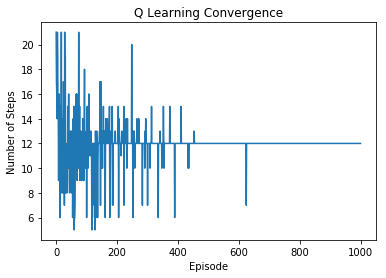

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
x = []
for i in range(1000):
    x.append(i)
y = agent.steps
plt.plot(x,y)
plt.ylabel('Number of Steps')
plt.xlabel('Episode')
plt.title('Q Learning Convergence')
plt.show()

In [9]:
past_all = []
for i in range(BOARD_ROWS):
    t = []
    for j in range(BOARD_COLS):
        t.append(False)
    past_all.append(t)
for i in range(BOARD_ROWS):
    for j in range(BOARD_COLS):
        print(past_all[i][j])

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
